In [93]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

from data_loading import read_table_to_df

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

import pickle

In [94]:
df = read_table_to_df(table_name="CHURN_TRAIN_TEST_DATASET")
df

Data from CHURN_TRAIN_TEST_DATASET loaded successfully!


,RowNumber,CustomerId,Surname,Age,EstimatedSalary,Balance,CreditScore,NumOfProducts,Geography,Gender,HasCrCard,IsActiveMember,Exited
0,1968,15598088,Ni,25,163221.22,0.00,559.0,2,Spain,Male,True,True,False
1,4126,15633378,Davidson,49,178342.63,0.00,692.0,2,Spain,Female,True,False,False
2,5850,15608873,Smith,51,53353.36,0.00,665.0,1,France,Male,False,False,False
3,4135,15684147,Palerma,43,79649.62,102338.19,678.0,1,France,Male,True,True,False
4,8130,15729246,Hardacre,31,76326.67,0.00,847.0,2,Spain,Male,True,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4994,2536,15578809,Hao,40,174434.06,134760.21,651.0,2,Germany,Male,False,False,True
4995,9427,15675518,Charlton,53,144849.10,75225.53,499.0,2,Spain,Female,False,False,True
4996,4608,15734524,Wang,51,170426.65,0.00,653.0,1,France,Male,True,False,True
4997,540,15762729,Ukaegbunam,28,73275.96,111071.36,745.0,1,Germany,Female,True,False,True


In [95]:
df = df.drop(columns=['RowNumber','CustomerId','Surname'])
numerical_cols = ['Age', 'EstimatedSalary', 'Balance','CreditScore', 'NumOfProducts'] 
categorical_cols = ['Geography','Gender', 'HasCrCard', 'IsActiveMember']
target_col = 'Exited'

In [96]:
df['HasCrCard'] = df['HasCrCard'].astype(int)
df['IsActiveMember'] = df['IsActiveMember'].astype(int)
df['Exited'] = df['Exited'].astype(int)

In [97]:
label_encoder = LabelEncoder()
df['Gender'] = label_encoder.fit_transform(df['Gender'])
df['Geography'] = label_encoder.fit_transform(df['Geography'])
df

,Age,EstimatedSalary,Balance,CreditScore,NumOfProducts,Geography,Gender,HasCrCard,IsActiveMember,Exited
0,25,163221.22,0.00,559.0,2,2,1,1,1,0
1,49,178342.63,0.00,692.0,2,2,0,1,0,0
2,51,53353.36,0.00,665.0,1,0,1,0,0,0
3,43,79649.62,102338.19,678.0,1,0,1,1,1,0
4,31,76326.67,0.00,847.0,2,2,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...
4994,40,174434.06,134760.21,651.0,2,1,1,0,0,1
4995,53,144849.10,75225.53,499.0,2,2,0,0,0,1
4996,51,170426.65,0.00,653.0,1,0,1,1,0,1
4997,28,73275.96,111071.36,745.0,1,1,0,1,0,1


In [98]:
min_value = df['CreditScore'].min() - 0.001
max_value = df['CreditScore'].max() + 0.001

num_categories = 3 

bins = np.linspace(min_value, max_value, num_categories + 1)
labels = ['1', '2', '3'] 

df['Segment'] = pd.cut(df['CreditScore'], bins=bins, labels=labels, right=False)
df['Segment'] = df['Segment'].astype(int)

df

,Age,EstimatedSalary,Balance,CreditScore,NumOfProducts,Geography,Gender,HasCrCard,IsActiveMember,Exited,Segment
0,25,163221.22,0.00,559.0,2,2,1,1,1,0,2
1,49,178342.63,0.00,692.0,2,2,0,1,0,0,3
2,51,53353.36,0.00,665.0,1,0,1,0,0,0,2
3,43,79649.62,102338.19,678.0,1,0,1,1,1,0,2
4,31,76326.67,0.00,847.0,2,2,1,1,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...
4994,40,174434.06,134760.21,651.0,2,1,1,0,0,1,2
4995,53,144849.10,75225.53,499.0,2,2,0,0,0,1,1
4996,51,170426.65,0.00,653.0,1,0,1,1,0,1,2
4997,28,73275.96,111071.36,745.0,1,1,0,1,0,1,3


In [99]:
y = df[target_col]  
X = df.drop(columns=[target_col])  

In [100]:
smote = SMOTE()
X, y = smote.fit_resample(X, y)
X

,Age,EstimatedSalary,Balance,CreditScore,NumOfProducts,Geography,Gender,HasCrCard,IsActiveMember,Segment
0,25,163221.220000,0.000000,559.000000,2,2,1,1,1,2
1,49,178342.630000,0.000000,692.000000,2,2,0,1,0,3
2,51,53353.360000,0.000000,665.000000,1,0,1,0,0,2
3,43,79649.620000,102338.190000,678.000000,1,0,1,1,1,2
4,31,76326.670000,0.000000,847.000000,2,2,1,1,1,3
...,...,...,...,...,...,...,...,...,...,...
7957,29,29698.561230,105153.354184,617.435464,1,1,0,0,1,2
7958,36,45334.725755,127033.713963,722.972636,1,0,0,0,0,2
7959,44,132253.318417,118488.296593,676.863694,1,1,0,0,0,2
7960,47,38825.028706,111030.444989,595.832095,1,1,0,1,1,1


In [101]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[-1.58651179,  1.09214285, -1.32818136, ...,  0.77568666,
         1.31404426, -0.28701089],
       [ 0.78232213,  1.35574647, -1.32818136, ...,  0.77568666,
        -0.76100937,  1.3773596 ],
       [ 0.97972496, -0.82312599, -1.32818136, ..., -1.28918034,
        -0.76100937, -0.28701089],
       ...,
       [ 0.28881506,  0.55229565,  0.59601909, ..., -1.28918034,
        -0.76100937, -0.28701089],
       [ 0.5849193 , -1.07639078,  0.4749067 , ...,  0.77568666,
         1.31404426, -1.95138138],
       [ 1.2758292 , -1.5285461 , -1.32818136, ..., -1.28918034,
        -0.76100937,  1.3773596 ]])

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

c:\Users\iman.hadi\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


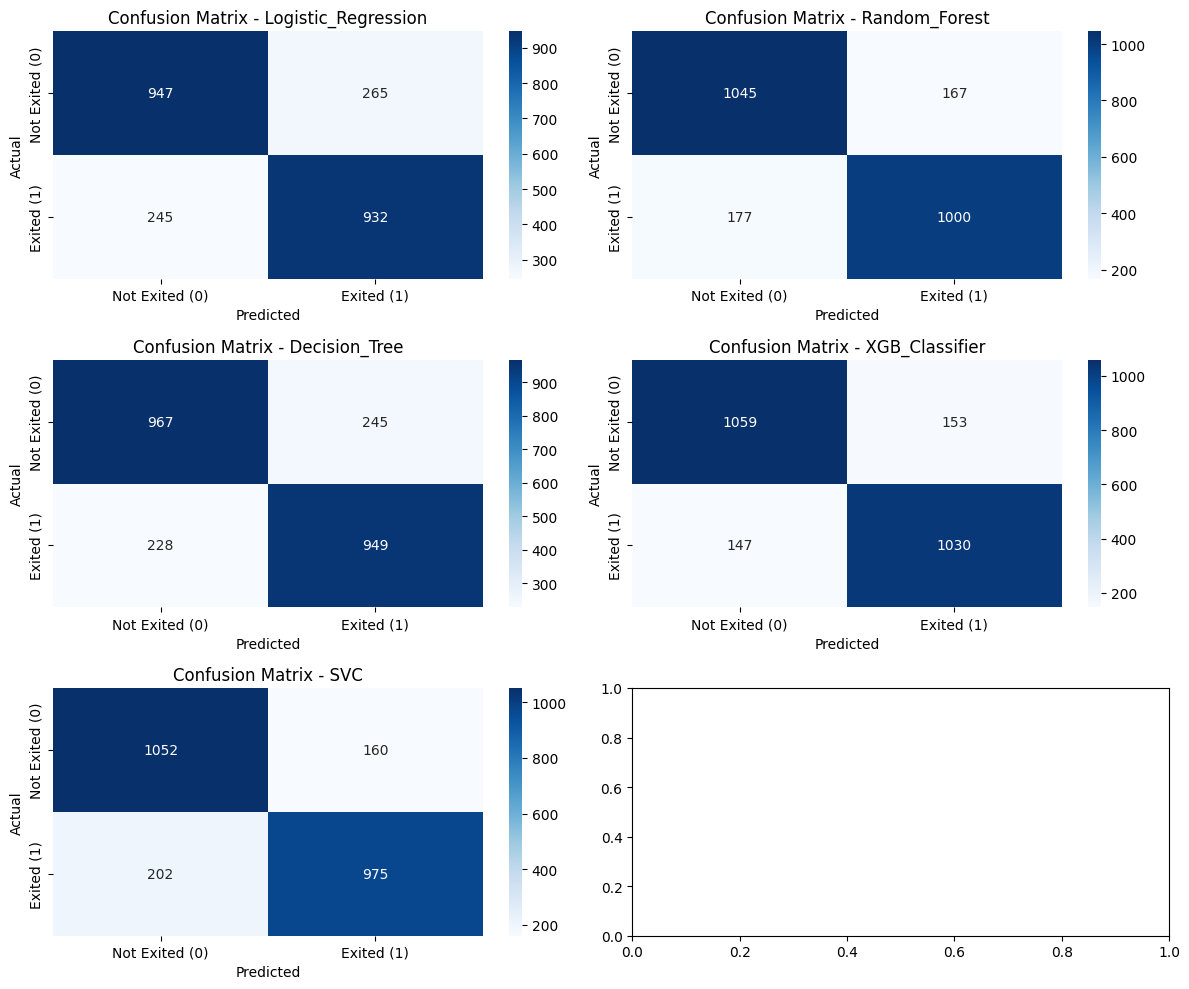

,Model,Accuracy,Precision_Exited_1,Recall_Exited_1,F1_Exited_1
0,XGB_Classifier,0.874424,0.870668,0.875106,0.872881
1,Random_Forest,0.856007,0.856898,0.849618,0.853242
2,SVC,0.848472,0.859031,0.828377,0.843426
3,Decision_Tree,0.802009,0.794807,0.806287,0.800506
4,Logistic_Regression,0.786522,0.778613,0.791844,0.785173


In [103]:
models = {
    'Logistic_Regression': LogisticRegression(),
    'Random_Forest': RandomForestClassifier(random_state=42),
    'Decision_Tree': DecisionTreeClassifier(),
    'Logistic_Regression': LogisticRegression(),
    'XGB_Classifier':  XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    'SVC': SVC()

}

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 10))
axes = axes.flatten() 
model_results = []

for idx, (model_name, model) in enumerate(models.items()):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(
        cm, 
        annot=True, 
        fmt='d', 
        cmap='Blues', 
        ax=axes[idx], 
        xticklabels=['Not Exited (0)', 'Exited (1)'], 
        yticklabels=['Not Exited (0)', 'Exited (1)']
    )
    
    axes[idx].set_xlabel('Predicted')
    axes[idx].set_ylabel('Actual')
    axes[idx].set_title(f'Confusion Matrix - {model_name}')

    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    precision_exited_1 = report['1']['precision']
    recall_exited_1 = report['1']['recall']
    f1_exited_1 = report['1']['f1-score']

    model_results.append([model_name, accuracy, precision_exited_1, recall_exited_1, f1_exited_1])

results_df = pd.DataFrame(model_results, columns=['Model', 'Accuracy', 'Precision_Exited_1', 'Recall_Exited_1', 'F1_Exited_1'])
results_df = results_df.sort_values(by='Recall_Exited_1', ascending=False).reset_index(drop=True)

plt.tight_layout()
plt.show()

results_df

In [104]:
for model_name, model in models.items():
    with open(f'model_pickles/{model_name}.pkl', 'wb') as file:  pickle.dump(model, file)